In [43]:
import pandas as pd, numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import os, scienceplots, cv2, tqdm, sys, json
from skimage import io

In [44]:
import scienceplots
import matplotlib.ticker as ticker
plt.style.use(['science'])
FIG_WIDTH = 7.5  # width of figure in inches (a4 width)
TARGET_FOLDER = "/home/masc12/dev/masc12-mthesis/eda/img-eda/plots"

In [45]:
webcams = ['altenrhein', 'ebenalp', 'golfclub-erlen', 'kronberg', 'romanshorn', 'rorschacherberg', 'sitterdorf', 'wiler-turm']
wbc_cmap = json.loads(open('webcam_colormap.json').read())

In [46]:
%%script false --no-raise-error

webcam_indicator = []
brightnesses = []
timesteps = []
filesizes = []

errors = []

for wbc in tqdm.tqdm(webcams):
    wbc = "ebenalp" if wbc == "elbenalp" else wbc
    for file in os.listdir(f'../data/{wbc}'):
        ts = dt.datetime.strptime(file, "%Y-%m-%d_%H-%M-%S.jpg")
        size = int(os.path.getsize(f'../data/{wbc}/{file}'))
        
        try:
            location = f'../data/{wbc}/{file}'
            
            try:
                _ = io.imread(location)
                img = cv2.imread(location)
                # Do stuff with img
            except Exception as e:
                errors.append(f"{location} \t {e}")
                print(location, e)

            # brightness = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)[:, :, 2].mean()
            brightness = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).mean()

        except Exception as e: 
            print(e)
            print(location)
            sys.exit()
        brightnesses.append(brightness)
        webcam_indicator.append(wbc)
        timesteps.append(ts)
        filesizes.append(size)

df_timesteps = pd.DataFrame({"webcam": webcam_indicator, "timestamp": timesteps, "brightness": brightnesses, "filesize": filesizes})	
df_timesteps.to_csv("image-intensity-df.csv", sep=";", encoding="utf-8", index=False)
with open("errors.txt", "w") as f:
    for error in errors:
        f.write(error + "\n")

In [47]:
df = pd.read_csv("temp/image-intensity-df.csv", sep=";", encoding="utf-8", parse_dates=["timestamp"])

# image intensity boxplot

count    119535.000000
mean        120.902454
std          29.137903
min           3.910146
25%         110.572766
50%         120.601459
75%         137.123280
max         220.111086
Name: brightness, dtype: float64


<Figure size 350x262.5 with 0 Axes>

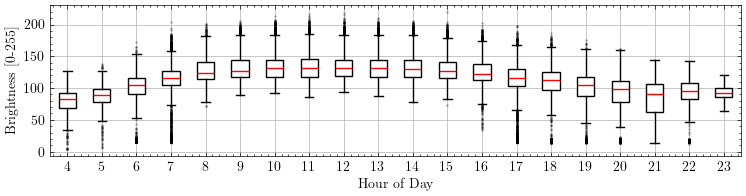

In [52]:
subset = df.copy()
plt.clf()
plt.figure(figsize=(FIG_WIDTH, 2))
# plt.title('Distribution of image brightness over day')
plt.ylabel('Brightness [0-255]')
plt.xlabel('Hour of Day')
plt.grid(True)
plt.gca().set_axisbelow(True)

plt.boxplot(
    [subset[subset.timestamp.dt.hour == h]["brightness"] for h in sorted(subset.timestamp.dt.hour.unique())], 
    tick_labels=sorted(subset.timestamp.dt.hour.unique()),
    patch_artist=True,
    boxprops=dict(facecolor='white', color='black'),
    medianprops=dict(color='red'),
    flierprops=dict(marker='o', markersize=1, markerfacecolor='black', linestyle='none', alpha=0.2),
)

# plt.xticks(
#     np.arange(0, 24, 2),
#     [f"{int(x)}" for x in np.arange(0, 24, 2)],
# )

print(subset["brightness"].describe())

plt.tight_layout(pad=0.5)
plt.savefig(f"{TARGET_FOLDER}/brightness-per-hour.png", dpi=300)
plt.show()

<Figure size 350x262.5 with 0 Axes>

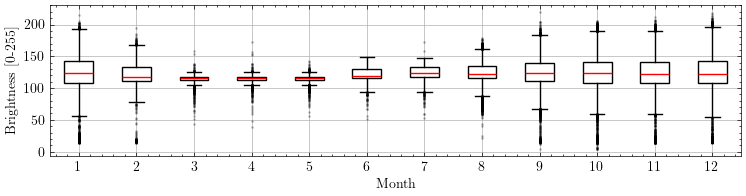

In [49]:
plt.clf()
plt.figure(figsize=(FIG_WIDTH, 2))
# plt.title('Distribution of image brightness (daily mean) over year')
plt.ylabel('Brightness [0-255]')
plt.xlabel('Month')
plt.grid(True)
plt.gca().set_axisbelow(True)
plt.boxplot(
    [subset[
        (subset.timestamp.dt.month == m)
    ]["brightness"] for m in sorted(df.timestamp.dt.month.unique())], 
    tick_labels=sorted(df.timestamp.dt.month.unique()),
    patch_artist=True,
    boxprops=dict(facecolor='white', color='black'),
    medianprops=dict(color='red'),
    flierprops=dict(marker='o', markersize=1, markerfacecolor='black', linestyle='none', alpha=0.2),
)
# SAVING
plt.tight_layout(pad=0.5)
plt.savefig(f"{TARGET_FOLDER}/brightness-per-month.png", dpi=300)
plt.show()

# asdf

In [50]:
lowest = df.groupby("webcam")["timestamp"].min().max() +  dt.timedelta(hours=10)
highest = df.groupby("webcam")["timestamp"].max().min() - dt.timedelta(hours=13, minutes=40)
lowest, highest

(Timestamp('2024-09-20 00:10:00'), Timestamp('2025-02-04 00:00:00'))

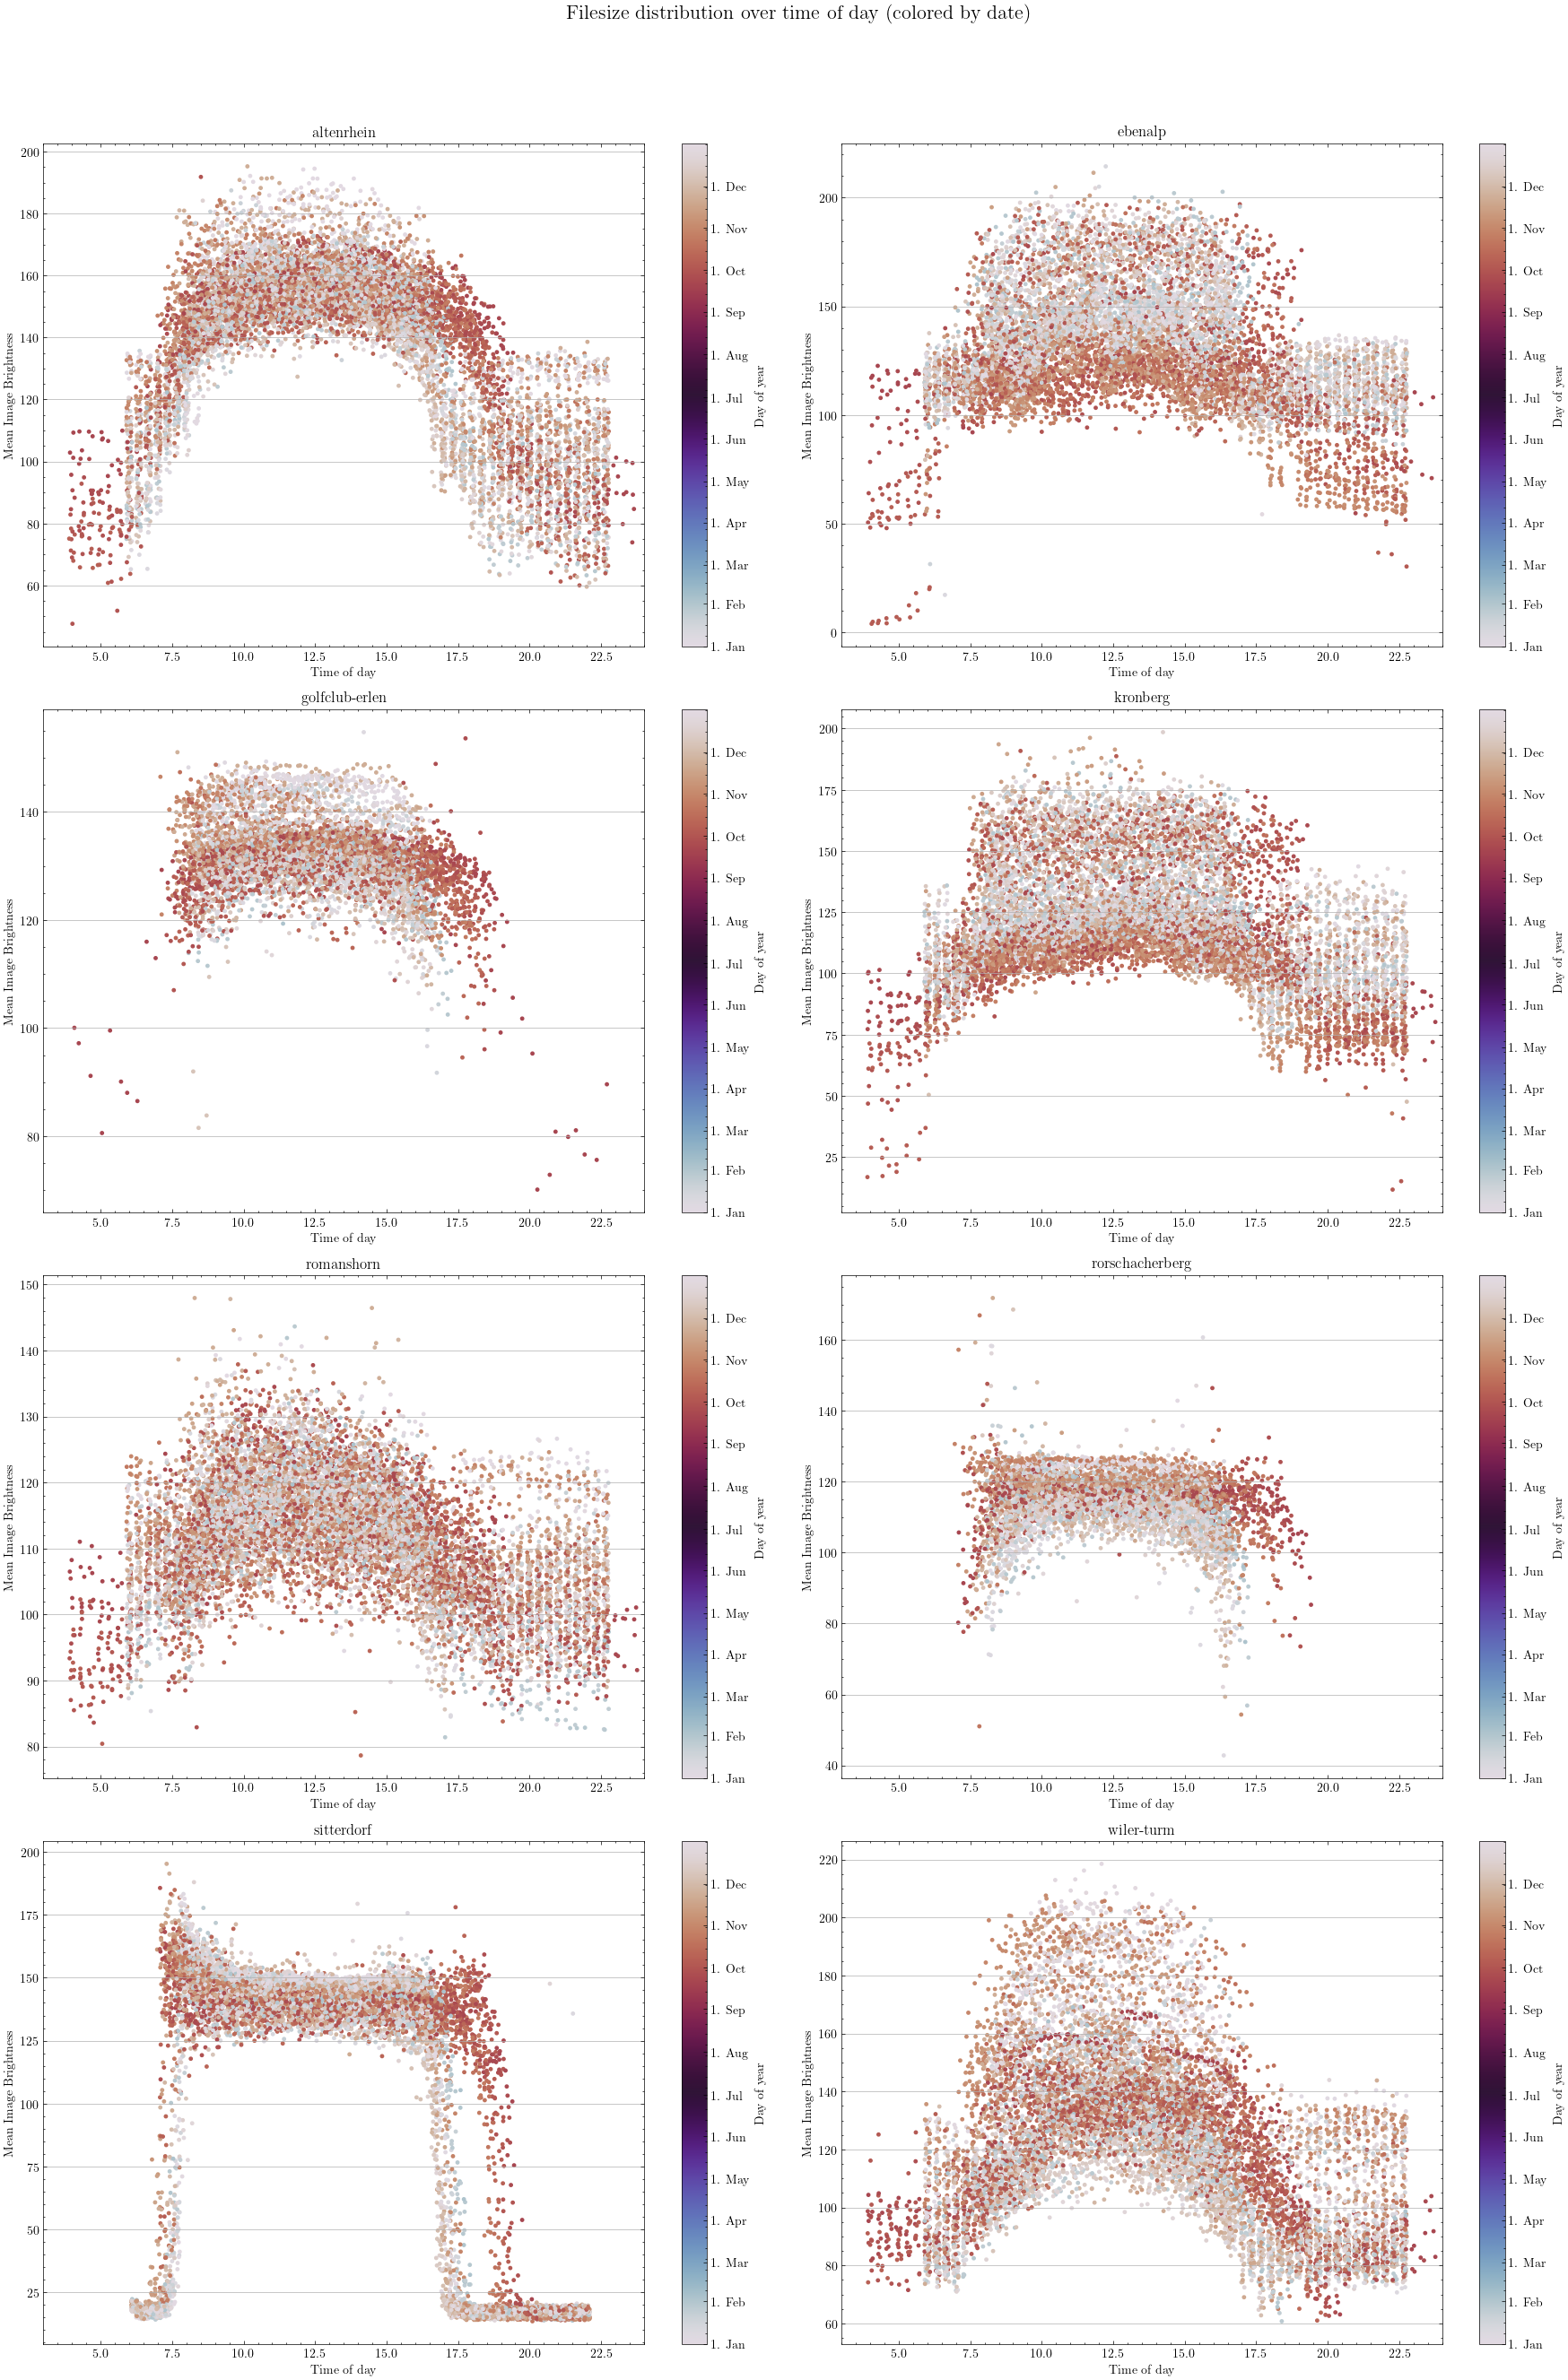

In [51]:
fig, axes = plt.subplots(4, 2, figsize=(18, 28))

for i, wbc in enumerate(webcams):
    ax = axes[i//2, i%2]
    subset = df[(df["webcam"] == wbc) & (df["timestamp"] >= lowest) & (df["timestamp"] <= highest)]
    dates_col = subset["timestamp"].dt.dayofyear

    time_x = subset["timestamp"].dt.hour + subset["timestamp"].dt.minute / 60
    jitter = np.random.uniform(-0.1, 0.1, size=len(time_x))  # Adjust the range as needed
    time_x_jittered = time_x + jitter
    
    scatter = ax.scatter(time_x_jittered, subset["brightness"], c=dates_col, cmap='twilight', s=6)
    ax.set_ylabel('Mean Image Brightness')

    ax.set_xlabel('Time of day')
    ax.set_xlim(3, 24)
    ax.grid(axis='y')
    ax.set_title(wbc)

    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Day of year')
    cbar.set_ticks([1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335])
    cbar.set_ticklabels(['1. Jan', '1. Feb', '1. Mar', '1. Apr', '1. May', '1. Jun', '1. Jul', '1. Aug', '1. Sep', '1. Oct', '1. Nov', '1. Dec'])

fig.suptitle('Filesize distribution over time of day (colored by date)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()